In [4]:
!pip install opencv-python
!pip install efficientnet
!pip install -U keras-efficientnet-v2

In [5]:
from PIL import Image
import numpy as np
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

# Copy every file from Input to working directory
import os
import shutil

# Define the source directory (where the input data is located)
source_directory = '/kaggle/input/'

# Define the destination directory (your notebook's working directory)
destination_directory = '/kaggle/working/'

for item in os.listdir(source_directory):
    source_item = os.path.join(source_directory, item)
    destination_item = os.path.join(destination_directory, item)

    if os.path.isdir(source_item):
        # Copy directories and their contents
        shutil.copytree(source_item, destination_item, dirs_exist_ok=True)
    else:
        # Copy individual files
        shutil.copy2(source_item, destination_item)
        
# Get the current working directory
current_directory = os.getcwd() + "/cellss";
        
# Define column names
column_names = ["Image_Path", "Defect_Probability", "Solar_Module_Type"]

# Read the CSV file with a custom separator (regex) and column names
csv_file_path = current_directory + "/labels.csv"  # Adjust the path if necessary
df = pd.read_csv(csv_file_path, sep=r'\s+', names=column_names)

# Create a new column with pairs of Defect_Probability and Solar_Module_Type
df['Probability_Module_Pair'] = df['Defect_Probability'].astype(str) + ' ' + df['Solar_Module_Type']

# Create a new column with pairs of Defect_Probability and Solar_Module_Type
df['Probability_Module_Pair'] = df['Defect_Probability'].astype(str) + ' ' + df['Solar_Module_Type']

from sklearn.preprocessing import LabelEncoder

# Encode "Solar_Module_Type" as 0 and 1
label_encoder = LabelEncoder()
df['Solar_Module_Type_Encoded'] = label_encoder.fit_transform(df['Solar_Module_Type'])

# Convert "Probability_Module_Pair" to a categorical variable
df['Probability_Module_Pair_Encoded'] = label_encoder.fit_transform(df['Probability_Module_Pair']) + 1

# Display the DataFrame with the encoded columns
df.head()

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
from efficientnet.keras import preprocess_input

def load_and_preprocess_image_efficient_net(image_path):
    # Load the image using PIL
    img = Image.open(current_directory + "/" + image_path)
    # Resize the image to a suitable size
    img = img.resize((224, 224))
    # Convert the PIL image to a NumPy array
    img_array = np.array(img)
    # Ensure the image has 3 color channels
    if img_array.shape[-1] != 3:
        img_array = np.stack((img_array,) * 3, axis=-1)

    # Preprocess the image using EfficientNetB0 preprocessing
    img_preprocessed = preprocess_input(img_array)
    return img_preprocessed

# Apply the load_and_preprocess_image function to the Image_Path column
df['Image_Data'] = df['Image_Path'].apply(load_and_preprocess_image_efficient_net)

# Create a TensorFlow dataset with image data and labels
image_data = np.stack(df['Image_Data'].values)
labels = df['Probability_Module_Pair_Encoded'].values

# Create a dataset
dataset = tf.data.Dataset.from_tensor_slices((image_data, labels))

# Shuffle and batch the dataset as needed
batch_size = 32
dataset = dataset.shuffle(buffer_size=len(df)).batch(batch_size)

# Print a few examples from the dataset
for image, label in dataset.take(3):
    print("Image shape:", image.shape)
    print("Label values:", label.numpy())

from sklearn.model_selection import train_test_split

# Split the dataset into a training set and a test set (e.g., 80% training, 20% testing)
train_data, test_data = train_test_split(df, test_size=0.25, random_state=42)

# Separate the image data and labels for the training and test sets
train_images = np.stack(train_data['Image_Data'].values)
train_labels = train_data['Probability_Module_Pair_Encoded'].values
test_images = np.stack(test_data['Image_Data'].values)
test_labels = test_data['Probability_Module_Pair_Encoded'].values

# Create TensorFlow datasets for training and testing
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_data)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size)

# Print a few examples from the training dataset
for image, label in train_dataset.take(3):
    print("Image shape (training):", image.shape)
    print("Label values (training):", label.numpy())

# Print a few examples from the test dataset
for image, label in test_dataset.take(3):
    print("Image shape (testing):", image.shape)
    print("Label values (testing):", label.numpy())



Image shape: (32, 224, 224, 3)
Label values: [6 2 8 4 2 7 1 4 2 8 3 8 1 2 4 7 1 2 1 2 2 8 2 1 2 8 1 4 8 1 2 8]
Image shape: (32, 224, 224, 3)
Label values: [2 8 8 5 8 6 2 1 2 4 7 4 2 7 8 2 7 1 1 7 1 1 2 8 1 8 2 7 4 8 7 8]
Image shape: (32, 224, 224, 3)
Label values: [2 2 5 2 2 1 2 1 8 2 2 7 2 2 7 1 1 2 1 7 2 2 8 2 4 2 1 4 1 2 3 1]
Image shape (training): (32, 224, 224, 3)
Label values (training): [2 2 2 2 5 2 3 8 1 2 8 1 1 8 8 2 1 1 2 2 2 1 2 4 2 2 5 1 2 1 7 1]
Image shape (training): (32, 224, 224, 3)
Label values (training): [1 7 2 2 1 1 2 7 7 2 2 8 2 2 1 1 2 2 8 8 1 7 1 3 7 7 2 2 8 8 1 2]
Image shape (training): (32, 224, 224, 3)
Label values (training): [2 2 2 1 1 4 4 1 2 2 2 3 2 8 3 8 1 7 8 1 2 2 5 1 7 8 2 2 1 8 4 1]
Image shape (testing): (32, 224, 224, 3)
Label values (testing): [8 4 1 7 2 2 1 7 2 2 1 8 2 3 7 1 2 6 2 7 2 1 2 7 1 2 7 7 2 8 5 2]
Image shape (testing): (32, 224, 224, 3)
Label values (testing): [2 1 4 1 1 4 6 8 4 8 2 1 8 1 2 2 1 1 2 1 2 2 1 8 8 1 1 4 5 2 1 7]
Image 

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
from efficientnet.keras import preprocess_input

def load_and_preprocess_image_efficient_net(image_path):
    # Load the image using PIL
    img = Image.open(current_directory + "/" + image_path)
    # Resize the image to a suitable size
    img = img.resize((224, 224))
    # Convert the PIL image to a NumPy array
    img_array = np.array(img)
    # Ensure the image has 3 color channels
    if img_array.shape[-1] != 3:
        img_array = np.stack((img_array,) * 3, axis=-1)

    # Preprocess the image using EfficientNetB0 preprocessing
    img_preprocessed = preprocess_input(img_array)
    return img_preprocessed

# Apply the load_and_preprocess_image function to the Image_Path column
df['Image_Data'] = df['Image_Path'].apply(load_and_preprocess_image_efficient_net)

# Create a TensorFlow dataset with image data and labels
image_data = np.stack(df['Image_Data'].values)
labels = df['Probability_Module_Pair_Encoded'].values

# Create a dataset
dataset = tf.data.Dataset.from_tensor_slices((image_data, labels))

# Shuffle and batch the dataset as needed
batch_size = 32
dataset = dataset.shuffle(buffer_size=len(df)).batch(batch_size)

# Print a few examples from the dataset
for image, label in dataset.take(3):
    print("Image shape:", image.shape)
    print("Label values:", label.numpy())


Image shape: (32, 224, 224, 3)
Label values: [2 2 1 2 2 2 8 6 2 3 1 1 2 2 2 8 2 4 2 8 2 8 2 1 1 2 8 1 8 2 2 2]
Image shape: (32, 224, 224, 3)
Label values: [7 2 8 2 2 2 2 2 4 7 8 7 2 2 1 8 7 2 2 8 2 7 2 7 8 7 8 8 4 8 7 1]
Image shape: (32, 224, 224, 3)
Label values: [2 1 2 8 1 7 2 8 2 1 2 8 8 6 8 1 1 8 1 1 2 1 8 2 1 1 2 2 2 1 8 8]


/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-s-21k.h5
Epoch 1/10
62/62 [==============================] - 38s 220ms/step - loss: 1.4445 - accuracy: 0.5920 - val_loss: 1.2091 - val_accuracy: 0.6479
Epoch 2/10
62/62 [==============================] - 9s 152ms/step - loss: 0.9464 - accuracy: 0.6860 - val_loss: 1.0796 - val_accuracy: 0.6540
Epoch 3/10
62/62 [==============================] - 9s 152ms/step - loss: 0.8129 - accuracy: 0.7043 - val_loss: 1.0049 - val_accuracy: 0.6860
Epoch 4/10
62/62 [==============================] - 9s 152ms/step - loss: 0.7481 - accuracy: 0.7297 - val_loss: 1.0530 - val_accuracy: 0.6814
Epoch 5/10
62/62 [==============================] - 10s 154ms/step - loss: 0.7311 - accuracy: 0.7266 - val_loss: 0.9849 - val_accuracy: 0.6875
Epoch 6/10
62/62 [==============================] - 10s 155ms/step - loss: 0.6404 - accuracy: 0.7642 - val_loss: 1.0512 - val_accuracy: 0.7149
Epoch 7/10
62/62 [==============================] - 10s 155

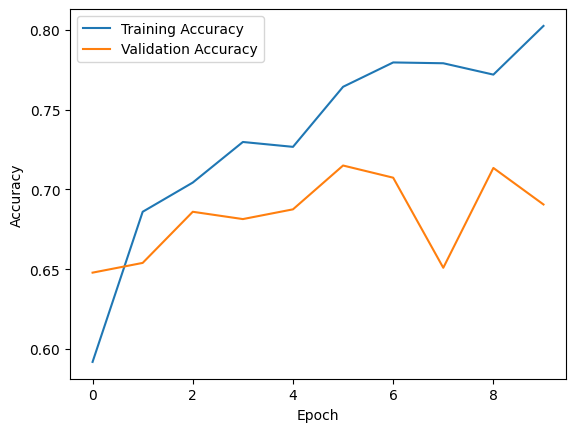

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientNetV2S (Functional  (None, 7, 7, 1280)       20331360  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 20,496,489
Trainable params: 165,129
Non-trainable params: 20,331,360
_________________________________________________________________


In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import keras_efficientnet_v2

base_model = keras_efficientnet_v2.EfficientNetV2S(
    num_classes=0,
    input_shape=(224, 224, 3),
    dropout=1e-6,
    pretrained="imagenet21k"
)
initializer1 = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform', seed=42)
initializer2 = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform', seed=43)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model and add layers
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_initializer=initializer1),
    layers.Dense(9, activation='softmax', kernel_initializer=initializer2)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using the training dataset, and use the test dataset for validation
epochs = 10  # Adjust the number of training epochs as needed

# Start training
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

# Optionally, you can visualize the training history
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Display the model summary
model.summary()

Epoch 1/10


2023-11-16 09:54:50.009065: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/62 [==============================] - 15s 127ms/step - loss: 1.7494 - accuracy: 0.3430 - val_loss: 1.7350 - val_accuracy: 0.3430
Epoch 2/10
62/62 [==============================] - 5s 78ms/step - loss: 1.7067 - accuracy: 0.3450 - val_loss: 1.7300 - val_accuracy: 0.3064
Epoch 3/10
62/62 [==============================] - 5s 78ms/step - loss: 1.6844 - accuracy: 0.3653 - val_loss: 1.6996 - val_accuracy: 0.3430
Epoch 4/10
62/62 [==============================] - 5s 78ms/step - loss: 1.6788 - accuracy: 0.3648 - val_loss: 1.7087 - val_accuracy: 0.3262
Epoch 5/10
62/62 [==============================] - 5s 78ms/step - loss: 1.6745 - accuracy: 0.3628 - val_loss: 1.7067 - val_accuracy: 0.3445
Epoch 6/10
62/62 [==============================] - 5s 78ms/step - loss: 1.6679 - accuracy: 0.3786 - val_loss: 1.6745 - val_accuracy: 0.3613
Epoch 7/10
62/62 [==============================] - 5s 78ms/step - loss: 1.6604 - accuracy: 0.3918 - val_loss: 1.6760 - val_accuracy: 0.3384
Epoch 8/10
62/62 [====

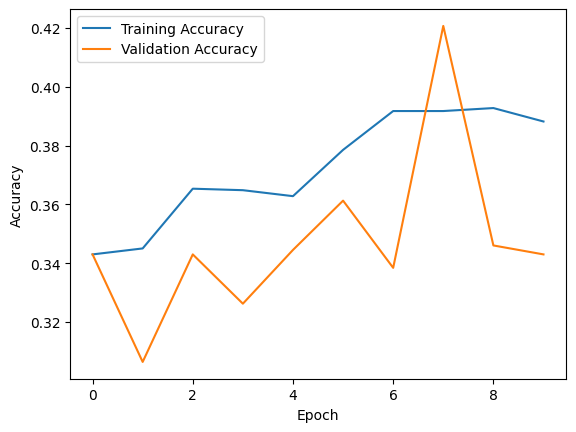

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 4,214,700
Trainable params: 165,129
Non-trainable params: 4,049,571
_________________________________________________________________


In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Define the EfficientNetB0 model with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model and add layers
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(seed=42)),
    layers.Dense(9, activation='softmax', kernel_initializer=tf.keras.initializers.VarianceScaling(seed=42))
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using the training dataset, and use the test dataset for validation
epochs = 10  # Adjust the number of training epochs as needed

# Start training
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

# Optionally, you can visualize the training history
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Display the model summary
model.summary()

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_preprocess_image_vgg16(image_path):
    # Load the image using Keras's load_img function
    
    img = load_img(current_directory + "/" + image_path, target_size=(224, 224))

    # Convert the image to a NumPy array
    img_array = img_to_array(img)
    
    # Expand the dimensions to create a batch (required by VGG16)
    # img_array = tf.expand_dims(img_array, 0)

    # Preprocess the image using VGG16 preprocessing
    img_preprocessed = preprocess_input(img_array)

    return img_preprocessed

# Apply the load_and_preprocess_image function to the Image_Path column
df['Image_Data'] = df['Image_Path'].apply(load_and_preprocess_image_vgg16)

# Create a TensorFlow dataset with image data and labels
image_data = np.stack(df['Image_Data'].values)
labels = df['Probability_Module_Pair_Encoded'].values

# Create a dataset
dataset = tf.data.Dataset.from_tensor_slices((image_data, labels))

# Shuffle and batch the dataset as needed
dataset = dataset.shuffle(buffer_size=len(df)).batch(batch_size)

# Print a few examples from the dataset
for image, label in dataset.take(3):
    print("Image shape:", image.shape)
    print("Label values:", label.numpy())

Image shape: (32, 224, 224, 3)
Label values: [7 2 2 4 7 2 1 7 2 2 7 2 8 1 2 2 1 2 1 2 1 2 2 2 2 1 2 7 1 2 7 2]
Image shape: (32, 224, 224, 3)
Label values: [7 2 2 2 8 1 8 7 3 7 2 2 1 2 1 1 5 7 1 4 2 4 1 7 8 8 2 8 1 1 2 7]
Image shape: (32, 224, 224, 3)
Label values: [2 7 1 4 7 4 3 2 2 2 1 1 2 1 8 2 7 8 3 2 1 1 1 7 1 4 1 8 1 7 4 2]


In [10]:
from sklearn.model_selection import train_test_split

# Split the dataset into a training set and a test set (e.g., 80% training, 20% testing)
train_data, test_data = train_test_split(df, test_size=0.25, random_state=42)

# Flatten and concatenate images and labels for the training set
# train_images = np.concatenate([np.array(images).reshape(-1, 224, 224, 3) for images in train_data['Image_Data']], axis=0)
train_images = np.stack(train_data['Image_Data'].values)
train_labels = train_data['Probability_Module_Pair_Encoded'].values

# Flatten and concatenate images and labels for the test set
# test_images = np.concatenate([np.array(images).reshape(-1, 224, 224, 3) for images in test_data['Image_Data']], axis=0)
test_images = np.stack(test_data['Image_Data'].values)
test_labels = test_data['Probability_Module_Pair_Encoded'].values

# Create TensorFlow datasets for training and testing
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_data)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size)

# Verify the shapes of the data
for image_batch, label_batch in train_dataset.take(1):
    print("Train batch image shape:", image_batch.shape)
    print("Train batch label shape:", label_batch.shape)

for image_batch, label_batch in test_dataset.take(1):
    print("Test batch image shape:", image_batch.shape)
    print("Test batch label shape:", label_batch.shape)

Train batch image shape: (32, 224, 224, 3)
Train batch label shape: (32,)
Test batch image shape: (32, 224, 224, 3)
Test batch label shape: (32,)


Epoch 1/10
62/62 [==============================] - 18s 205ms/step - loss: 1.1090 - accuracy: 0.6443 - val_loss: 0.8344 - val_accuracy: 0.6997
Epoch 2/10
62/62 [==============================] - 10s 161ms/step - loss: 0.7427 - accuracy: 0.7307 - val_loss: 0.7917 - val_accuracy: 0.7149
Epoch 3/10
62/62 [==============================] - 10s 161ms/step - loss: 0.6890 - accuracy: 0.7459 - val_loss: 0.8027 - val_accuracy: 0.7012
Epoch 4/10
62/62 [==============================] - 10s 161ms/step - loss: 0.6568 - accuracy: 0.7510 - val_loss: 0.7358 - val_accuracy: 0.7363
Epoch 5/10
62/62 [==============================] - 10s 161ms/step - loss: 0.6226 - accuracy: 0.7678 - val_loss: 0.7374 - val_accuracy: 0.7134
Epoch 6/10
62/62 [==============================] - 10s 159ms/step - loss: 0.5972 - accuracy: 0.7759 - val_loss: 0.7345 - val_accuracy: 0.7271
Epoch 7/10
62/62 [==============================] - 10s 159ms/step - loss: 0.5627 - accuracy: 0.7957 - val_loss: 0.6940 - val_accuracy: 0.7424

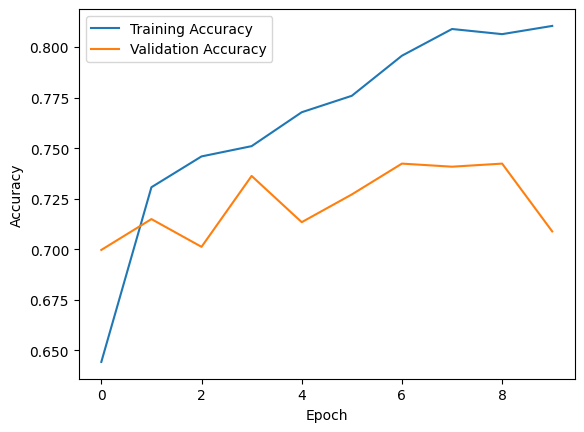

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 14,781,513
Trainable params: 66,825
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False 

# Create a Sequential model and add layers
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # Output layer with 9 classes (adjust as needed)
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 10

history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Display the model summary
model.summary()

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet import preprocess_input

def load_and_preprocess_image_resnet(image_path):
    # Load the image using Keras's load_img function
    img = load_img(current_directory + "/" + image_path, target_size=(224, 224))

    # Convert the image to a NumPy array
    img_array = img_to_array(img)
    
    # Expand the dimensions to create a batch (required by ResNet)
    img_array = tf.expand_dims(img_array, 0)

    # Preprocess the image using ResNet preprocessing
    img_preprocessed = preprocess_input(img_array)

    return img_preprocessed

# Apply the load_and_preprocess_image_resnet function to the Image_Path column
df['Image_Data_ResNet'] = df['Image_Path'].apply(load_and_preprocess_image_resnet)

# Create a TensorFlow dataset with image data and labels
image_data_resnet = np.vstack(df['Image_Data_ResNet'].values)
labels_resnet = df['Probability_Module_Pair_Encoded'].values

# Create a dataset
dataset_resnet = tf.data.Dataset.from_tensor_slices((image_data_resnet, labels_resnet))

# Shuffle and batch the dataset as needed
dataset_resnet = dataset_resnet.shuffle(buffer_size=len(df)).batch(batch_size)

# Print a few examples from the dataset
for image, label in dataset_resnet.take(3):
    print("Image shape:", image.shape)
    print("Label values:", label.numpy())

Image shape: (32, 224, 224, 3)
Label values: [2 2 1 4 2 7 2 5 2 2 5 8 1 2 2 2 2 1 2 1 2 7 5 2 5 6 7 3 4 1 8 2]
Image shape: (32, 224, 224, 3)
Label values: [2 2 4 8 2 1 8 1 8 1 5 1 8 4 2 2 7 2 2 1 5 2 2 2 2 2 2 7 3 7 1 2]
Image shape: (32, 224, 224, 3)
Label values: [2 1 2 5 1 7 4 3 2 1 2 3 2 2 2 2 2 7 3 1 1 1 5 1 1 2 1 1 7 7 7 2]


In [13]:
# Split the dataset into a training set and a test set (e.g., 80% training, 20% testing)
train_data, test_data = train_test_split(df, test_size=0.25, random_state=42)

# Flatten and concatenate images and labels for the training set
# train_images = np.concatenate([np.array(images).reshape(-1, 224, 224, 3) for images in train_data['Image_Data']], axis=0)
train_images = np.stack(train_data['Image_Data'].values)
train_labels = train_data['Probability_Module_Pair_Encoded'].values

# Flatten and concatenate images and labels for the test set
# test_images = np.concatenate([np.array(images).reshape(-1, 224, 224, 3) for images in test_data['Image_Data']], axis=0)
test_images = np.stack(test_data['Image_Data'].values)
test_labels = test_data['Probability_Module_Pair_Encoded'].values

# Create TensorFlow datasets for training and testing
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_data)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size)

# Verify the shapes of the data
for image_batch, label_batch in train_dataset.take(1):
    print("Train batch image shape:", image_batch.shape)
    print("Train batch label shape:", label_batch.shape)

for image_batch, label_batch in test_dataset.take(1):
    print("Test batch image shape:", image_batch.shape)
    print("Test batch label shape:", label_batch.shape)

Train batch image shape: (32, 224, 224, 3)
Train batch label shape: (32,)
Test batch image shape: (32, 224, 224, 3)
Test batch label shape: (32,)


Epoch 1/10
62/62 [==============================] - 16s 158ms/step - loss: 0.9370 - accuracy: 0.6885 - val_loss: 0.7803 - val_accuracy: 0.7271
Epoch 2/10
62/62 [==============================] - 8s 122ms/step - loss: 0.7108 - accuracy: 0.7383 - val_loss: 0.8249 - val_accuracy: 0.6951
Epoch 3/10
62/62 [==============================] - 8s 123ms/step - loss: 0.6716 - accuracy: 0.7475 - val_loss: 0.7099 - val_accuracy: 0.7271
Epoch 4/10
62/62 [==============================] - 8s 123ms/step - loss: 0.6037 - accuracy: 0.7724 - val_loss: 0.7231 - val_accuracy: 0.7729
Epoch 5/10
62/62 [==============================] - 8s 124ms/step - loss: 0.5646 - accuracy: 0.7917 - val_loss: 0.6963 - val_accuracy: 0.7515
Epoch 6/10
62/62 [==============================] - 8s 124ms/step - loss: 0.5533 - accuracy: 0.7983 - val_loss: 0.7140 - val_accuracy: 0.7409
Epoch 7/10
62/62 [==============================] - 8s 123ms/step - loss: 0.5062 - accuracy: 0.8161 - val_loss: 0.6882 - val_accuracy: 0.7622
Epoch

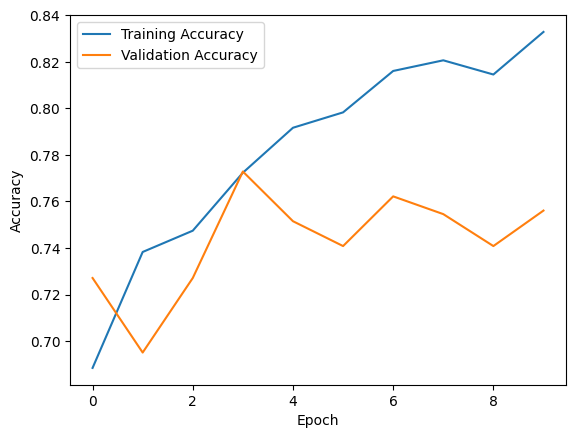

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dense_7 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 23,851,145
Trainable params: 263,433
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 base model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Create a Sequential model and add layers
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # Output layer with 4 classes (adjust as needed)
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 10

history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Display the model summary
model.summary()


**Implement Data Augmentation, Batch Normalisation And Fine Tuning**

Epoch 1/10
123/123 [==============================] - 15s 77ms/step - loss: 1.1431 - accuracy: 0.6550 - val_loss: 0.9307 - val_accuracy: 0.6524
Epoch 2/10
123/123 [==============================] - 9s 66ms/step - loss: 0.8194 - accuracy: 0.7297 - val_loss: 0.7837 - val_accuracy: 0.7119
Epoch 3/10
123/123 [==============================] - 9s 66ms/step - loss: 0.7404 - accuracy: 0.7368 - val_loss: 0.8701 - val_accuracy: 0.6936
Epoch 4/10
123/123 [==============================] - 9s 66ms/step - loss: 0.6348 - accuracy: 0.7663 - val_loss: 0.8515 - val_accuracy: 0.7149
Epoch 5/10
123/123 [==============================] - 9s 67ms/step - loss: 0.6462 - accuracy: 0.7688 - val_loss: 0.9249 - val_accuracy: 0.7195
Epoch 6/10
123/123 [==============================] - 9s 66ms/step - loss: 0.5578 - accuracy: 0.7942 - val_loss: 0.9530 - val_accuracy: 0.6890
Epoch 7/10
123/123 [==============================] - 9s 66ms/step - loss: 0.5364 - accuracy: 0.8145 - val_loss: 0.8268 - val_accuracy: 0.747

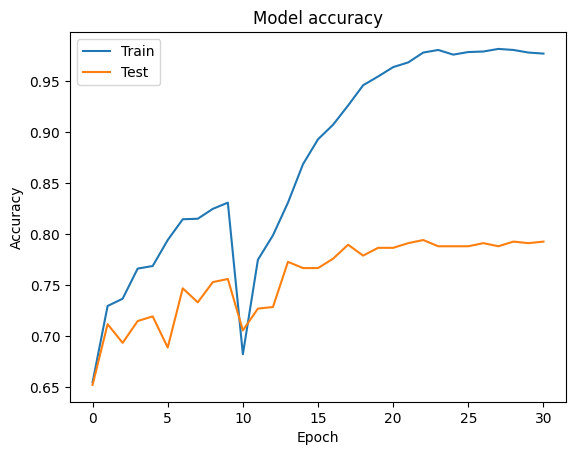

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_18 (Dense)            (None, 128)               262272    
                                                                 
 dense_19 (Dense)            (None, 9)                 1161      
                                                                 
Total params: 23,859,337
Trainable params: 19,720,457


In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

batch_size = 16
input_shape = (224, 224, 3)

# Function to load and preprocess the image
def load_and_preprocess_image_resnet(image_path):
    img = load_img(current_directory + "/" + image_path, target_size=input_shape[:2])
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array) 
    return img_array

# Apply the load_and_preprocess_image function to the Image_Path column
df['Image_Data'] = df['Image_Path'].apply(load_and_preprocess_image_resnet)

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.25, random_state=42)

# Convert the stacked image data and labels to numpy arrays
train_images = np.stack(train_data['Image_Data'].values)
train_labels = train_data['Probability_Module_Pair_Encoded'].values.astype(np.int32)
test_images = np.stack(test_data['Image_Data'].values)
test_labels = test_data['Probability_Module_Pair_Encoded'].values.astype(np.int32)

# Function to apply data augmentation
def augment_data(image, label):
    # Random flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    return image, label

# Create tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).map(augment_data).shuffle(buffer_size=len(train_data)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

# Load the ResNet50 base model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model and add layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')
])

# Compile the model with initial learning rate
initial_learning_rate = 1e-3
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def lr_schedule(epoch, lr):
    if epoch > 25:
        lr *= 0.2  # Decrease learning rate by 5x
    elif epoch > 20:
        lr *= 0.5  # Decrease learning rate by 2x
    elif epoch > 15:
        lr *= 0.7  # Decrease learning rate by 1.5x
    elif epoch > 0:
        lr *= 0.9  # Decrease learning rate by 1.1x
    print('Learning rate: ', lr)
    return lr

# Instantiate the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# First phase of training (with the base model frozen)
initial_epochs = 10
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=test_dataset)

# Unfreeze the top layers of the model
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

# Compile the model with a lower learning rate for fine-tuning
fine_tune_learning_rate = 1e-4
model.compile(optimizer=Adam(learning_rate=fine_tune_learning_rate), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Continue training (fine-tuning)
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset,
                         callbacks=[lr_scheduler])

# Plot training history
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Display the model summary
model.summary()


**Change the strategy!**

In [ ]:
# Split the data into mono and poly datasets
mono_df = df[df['Solar_Module_Type'] == 'mono']
poly_df = df[df['Solar_Module_Type'] == 'poly']

# Display the shape of the mono and poly datasets
print("Mono dataset shape:", mono_df.shape)
print("Poly dataset shape:", poly_df.shape)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_preprocess_image_vgg16(image_path):
    # Load the image using Keras's load_img function
    img = load_img(current_directory + "/" + image_path, target_size=(224, 224))

    # Convert the image to a NumPy array
    img_array = img_to_array(img)
    
    # Expand the dimensions to create a batch (required by VGG16)
    # img_array = tf.expand_dims(img_array, 0)

    # Preprocess the image using VGG16 preprocessing
    img_preprocessed = preprocess_input(img_array)

    return img_preprocessed

# Apply the load_and_preprocess_image function to the Image_Path column
df['Image_Data'] = df['Image_Path'].apply(load_and_preprocess_image_vgg16)

# Create a TensorFlow dataset with image data and labels
mono_image_data = np.stack(mono_df['Image_Data'].values)
labels = mono_df['Defect_Probability'].values

# Create a dataset
dataset = tf.data.Dataset.from_tensor_slices((mono_image_data, labels))

# Shuffle and batch the dataset as needed
batch_size = 32
dataset = dataset.shuffle(buffer_size=len(df)).batch(batch_size)

# Print a few examples from the dataset
for image, label in dataset.take(3):
    print("Image shape:", image.shape)
    print("Label values:", label.numpy())

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into a training set and a test set (e.g., 80% training, 20% testing)
train_data, test_data = train_test_split(mono_df, test_size=0.25, random_state=42)

# Flatten and concatenate images and labels for the training set
mono_train_images = np.stack(train_data['Image_Data'].values)
mono_train_labels = train_data['Defect_Probability'].values

# Flatten and concatenate images and labels for the test set
mono_test_images = np.stack(test_data['Image_Data'].values)
mono_test_labels = test_data['Defect_Probability'].values

# Create TensorFlow datasets for training and testing
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((mono_train_images, mono_train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_data)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((mono_test_images, mono_test_labels))
test_dataset = test_dataset.batch(batch_size)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False 

# Create a Sequential model and add layers
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Output layer with 9 classes (adjust as needed)
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 10

history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Display the model summary
model.summary()

In [ ]:
# Create a TensorFlow dataset with image data and labels
poly_image_data = np.stack(poly_df['Image_Data'].values)
labels = poly_df['Defect_Probability'].values

# Create a dataset
dataset = tf.data.Dataset.from_tensor_slices((poly_image_data, labels))

# Shuffle and batch the dataset as needed
batch_size = 32
dataset = dataset.shuffle(buffer_size=len(df)).batch(batch_size)

# Print a few examples from the dataset
for image, label in dataset.take(3):
    print("Image shape:", image.shape)
    print("Label values:", label.numpy())

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into a training set and a test set (e.g., 80% training, 20% testing)
train_data, test_data = train_test_split(poly_df, test_size=0.25, random_state=42)

# Flatten and concatenate images and labels for the training set
# train_images = np.concatenate([np.array(images).reshape(-1, 224, 224, 3) for images in train_data['Image_Data']], axis=0)
poly_train_images = np.stack(train_data['Image_Data'].values)
poly_train_labels = train_data['Defect_Probability'].values

# Flatten and concatenate images and labels for the test set
# test_images = np.concatenate([np.array(images).reshape(-1, 224, 224, 3) for images in test_data['Image_Data']], axis=0)
poly_test_images = np.stack(test_data['Image_Data'].values)
poly_test_labels = test_data['Defect_Probability'].values

# Create TensorFlow datasets for training and testing
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((poly_train_images, poly_train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_data)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((poly_test_images, poly_test_labels))
test_dataset = test_dataset.batch(batch_size)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False 

# Create a Sequential model and add layers
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Output layer with 9 classes (adjust as needed)
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 10

history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Display the model summary
model.summary()